<a href="https://colab.research.google.com/github/surajsrivathsa/image_registration/blob/main/Disentangled_Latent_space_for_MRI_Harmonization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [ ]:
# !pip install --upgrade nibabel
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=1ca6545c9b142d798e6977ee90efbfdeb8dac7c55606a335374750173979ac04
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


In [ ]:
import warnings
import os
warnings.filterwarnings("ignore")
import numpy as np
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import nibabel as nb
import os, sys, glob
from google.colab import drive
drive.mount('/content/drive')
print()

1.8.1+cu101
0.9.1+cu101
Mounted at /content/drive



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import collections
from torch.autograd import Variable

In [ ]:
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from torchviz import make_dot
import urllib
from random import randint, seed
seed(1)

In [ ]:
#data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/"
data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T1_Train_50_Reg_downsampled_hm_znm/" 
data_path_t2 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T2-T1/"
ixi_xls_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/IXI.xls"
file_names_t1 = sorted(glob.glob(os.path.join(data_path_t1, "*.nii.gz")))
file_names_t2 = sorted(glob.glob(os.path.join(data_path_t2, "*.nii.gz")))

In [ ]:
file_names_t1[0:3]

['/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T1_Train_50_Reg_downsampled_hm_znm/reg_IXI430-IOP-0990-T1_downsampled_hm_zscore.nii.gz',
 '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T1_Train_50_Reg_downsampled_hm_znm/reg_IXI438-HH-2155-T1_downsampled_hm_zscore.nii.gz',
 '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T1_Train_50_Reg_downsampled_hm_znm/reg_IXI439-HH-2114-T1_downsampled_hm_zscore.nii.gz']

In [ ]:
file_names_t2[0:3]

['/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T2-T1/T2-T1reg_IXI430-IOP-0990-T1_downsampled_hm_zscore.nii.gz',
 '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T2-T1/T2-T1reg_IXI438-HH-2155-T1_downsampled_hm_zscore.nii.gz',
 '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T2-T1/T2-T1reg_IXI439-HH-2114-T1_downsampled_hm_zscore.nii.gz']

In [ ]:
ixi_df = pd.read_excel(ixi_xls_path, sheet_name="Table")
ixi_df.head()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE
0,1,1,170,80,2,3,5,2,1968-02-22,0,NaT,NaN
1,2,2,164,58,1,4,1,5,1970-01-30,1,2005-11-18,35.800137
2,12,1,175,70,1,2,1,5,1966-08-20,1,2005-06-01,38.781656
3,13,1,182,70,1,2,1,5,1958-09-15,1,2005-06-01,46.710472
4,14,2,163,65,1,4,1,5,1971-03-15,1,2005-06-09,34.236824


In [ ]:
ixi_df.drop_duplicates(subset=['IXI_ID'], keep='first', inplace=True)

In [ ]:
count = 0
ixi_id = []
scanner_name = []
contrast_type = []
file_path = []
for root, dirs, files in os.walk(data_path_t1):
  for file in files:
    parameters_search = re.search('reg_IXI(\d*)-(\w*)-(\d*)-(\w*)_downsampled_hm_zscore(.*?)', file, re.IGNORECASE)
    
    if parameters_search:
      ixi_id.append(int(parameters_search.group(1)))
      scanner_name.append(parameters_search.group(2))
      contrast_type.append(parameters_search.group(4))
      file_path.append(os.path.join(data_path_t1, file))
  
    count = count+1
  
  print("processed T1 {} files".format(count))

for root, dirs, files in os.walk(data_path_t2):
  for file in files:
    parameters_search = re.search('T2-T1reg_IXI(\d*)-(\w*)-(\d*)-(\w*)_downsampled_hm_zscore(.*?)', file, re.IGNORECASE)
    
    if parameters_search:
      ixi_id.append(int(parameters_search.group(1)))
      scanner_name.append(parameters_search.group(2))
      #contrast_type.append(parameters_search.group(4))
      contrast_type.append("T2")
      file_path.append(os.path.join(data_path_t2, file))
  
    count = count+1
  
  print("processed T2 {} files".format(count))

processed T1 49 files
processed T2 98 files


In [ ]:
our_df = pd.DataFrame(data={"our_ixi_id": ixi_id, "scanner_name": scanner_name, "contrast_type": contrast_type, "file_path": file_path} )
our_df.head()

,our_ixi_id,scanner_name,contrast_type,file_path
0,452,HH,T1,/content/drive/My Drive/Image_Registration_Pro...
1,534,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
2,527,HH,T1,/content/drive/My Drive/Image_Registration_Pro...
3,571,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...
4,633,HH,T1,/content/drive/My Drive/Image_Registration_Pro...


In [ ]:
filtered_df = pd.merge(left = ixi_df, right=our_df, left_on="IXI_ID", right_on="our_ixi_id", how="inner")

In [ ]:
filtered_df.columns = ['IXI_ID', 'SEX_ID', 'HEIGHT', 'WEIGHT', 'ETHNIC_ID',
       'MARITAL_ID', 'OCCUPATION_ID', 'QUALIFICATION_ID', 'DOB',
       'DATE_AVAILABLE', 'STUDY_DATE', 'AGE', 'our_ixi_id', 'scanner_name',
       'contrast_type', 'file_path']

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", "90-100"]
filtered_df['age_disc'] = pd.cut(filtered_df['AGE'], bins=bins, labels=labels)

# Dataset Analyses

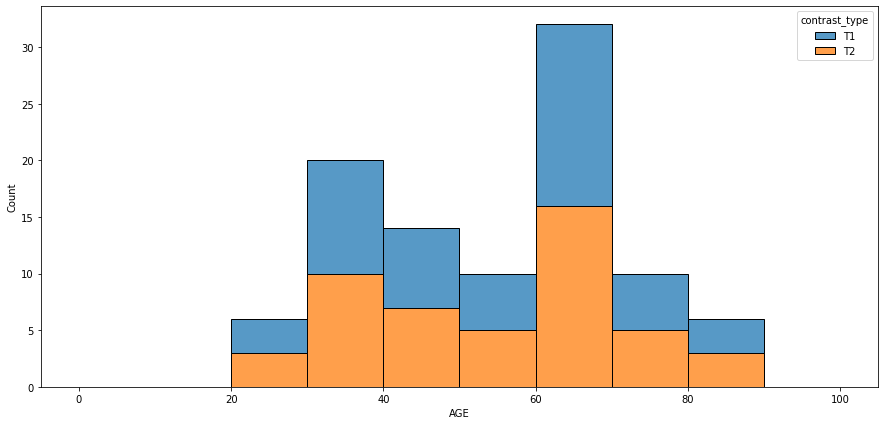

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(data=filtered_df,x="AGE", hue="contrast_type", multiple="stack", binwidth=10, binrange=(0,100))

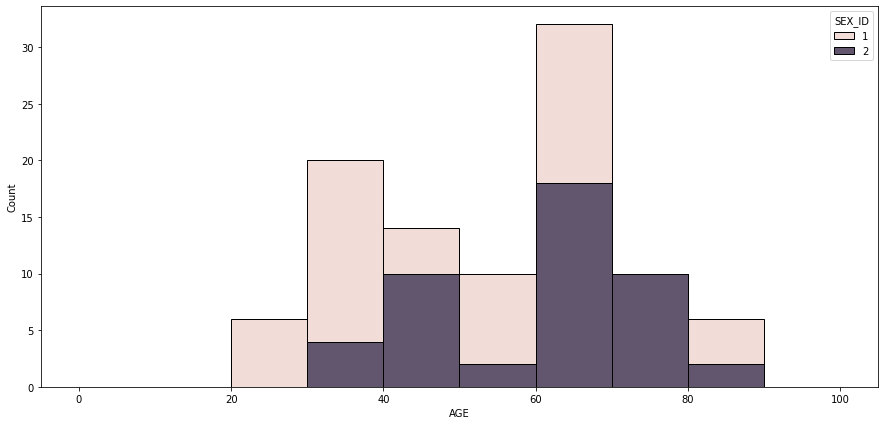

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(data=filtered_df,x="AGE", hue="SEX_ID", multiple="stack", binwidth=10, binrange=(0,100))

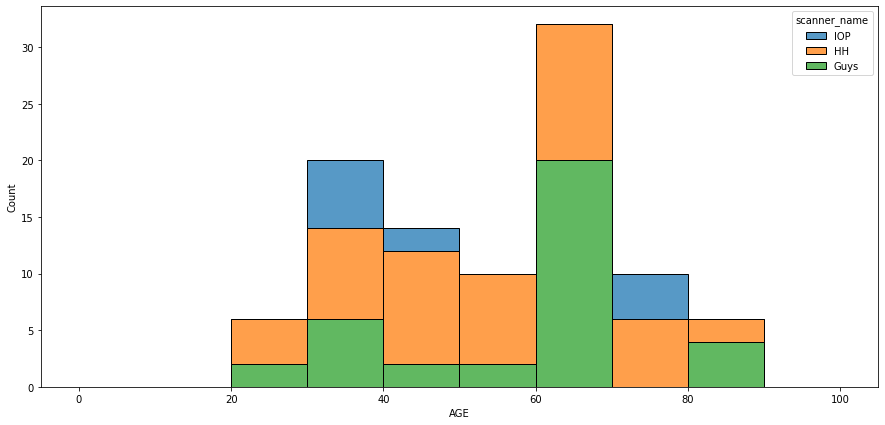

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(data=filtered_df,x="AGE", hue="scanner_name", multiple="stack", binwidth=10, binrange=(0,100))

# Dataset Creation

In [ ]:
def place_into_buckets(age_disc, scanner_name, contrast_type, SEX_ID):
    """ 
    flag 0,1,2 = learn, unlearn, validation
    - From IOP if its between 50-70 put it in unlearn bucket
    - From IOP if its not between 50-70 put it learn and validation bucket with probs of 0.75 and 0.25
    - From others put it in learn with 0.4, in unlearn with 0.3, in validation with 0.3 prob
    """
    """
    - After addition of T2 images we removed the above conditionals,
    - We will remove IOP from dataset as its distribution is completely different than other two.
    - Use flag = 3 as no train/test/validation bucket to place IOP data.
    - Later another test IOP will be added and above conditionals will be used
    """

    if ((scanner_name == "IOP")):
      flag = np.random.choice(a=[0, 1, 2], p=[0.8, 0.0, 0.2] )
    if ((scanner_name == "Guys")):
      flag = np.random.choice(a=[0, 1, 2], p=[0.7, 0.0, 0.3] )
      #flag = -1
    else:
      flag = np.random.choice(a=[0, 1, 2], p=[0.6, 0.0, 0.4] )

    # flag = np.random.choice(a=[0, 1, 2], p=[0.75, 0.00, 0.25] )

    if (flag == 0):
      return "train_learn"
    elif (flag == 1):
      return "train_unlearn"
    elif (flag == 2):
        return "validation"
    else:
      return "nouse"

    # if ((scanner_name == "IOP") and (age_disc in ["50-60", "60-70"]) ):
    #   flag = 1
    # elif ((scanner_name == "IOP") and (age_disc not in ["50-60", "60-70"]) ):
    #   flag = np.random.choice(a=[0, 2], p= [0.75, 0.25])
    # else:
    #   flag = np.random.choice(a=[0, 1, 2], p=[0.5, 0.3, 0.2] )

    # if (flag == 0):
    #   return "train_learn"
    # elif (flag == 1):
    #   return "train_unlearn"
    # else:
    #     return "validation"
        


In [ ]:
def categorize_scanner( scanner_name):
    """ 
    flag 0,1,2 = IOP, Guys, HH
    """
    
    if (scanner_name == "HH") :
      flag = 0
    elif (scanner_name == "Guys"):
      flag = 1
    else:
      flag = 2

    return flag

In [ ]:
def categorize_contrast(contrast_type):
    """ 
    flag 0,1 = T1, T2
    
    """
    
    if (contrast_type == "T1") :
      flag = 0
    elif (contrast_type == "T2"):
      flag = 1
    else:
      flag = -1

    return flag

In [ ]:
def categorize_sex( SEX_ID):
    """ 
    flag 1,2 = F, M
    """
    
    if (SEX_ID == 1) :
      flag = 0
    elif (SEX_ID == 2):
      flag = 1
    else:
      flag = -1

    return flag

In [ ]:
filtered_df['dataset_flag'] = filtered_df.apply(lambda x: place_into_buckets(x['age_disc'],x['scanner_name'], x['contrast_type'], x["SEX_ID"]),axis=1)

In [ ]:
filtered_df["scanner_flag"] = filtered_df.apply(lambda x: categorize_scanner(x['scanner_name']),axis=1)

In [ ]:
filtered_df["contrast_flag"] = filtered_df.apply(lambda x: categorize_contrast(x['contrast_type']),axis=1)

In [ ]:
filtered_df["sex_flag"] = filtered_df.apply(lambda x: categorize_sex(x['SEX_ID']),axis=1)

In [ ]:
filtered_df.describe()

,IXI_ID,SEX_ID,HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DATE_AVAILABLE,AGE,our_ixi_id,scanner_flag,contrast_flag,sex_flag
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.0,98.000000,98.000000,98.000000,98.000000,98.000000
mean,545.775510,1.469388,204.612245,70.367347,1.265306,2.346939,3.204082,3.714286,1.0,55.188702,545.775510,0.612245,0.500000,0.469388
std,66.209061,0.501628,238.908067,17.070737,0.856160,1.324644,2.110158,1.435916,0.0,15.986628,66.209061,0.698048,0.502571,0.501628
min,430.000000,1.000000,152.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0,24.876112,430.000000,0.000000,0.000000,0.000000
25%,494.000000,1.000000,163.000000,60.000000,1.000000,1.000000,1.000000,2.000000,1.0,39.383984,494.000000,0.000000,0.000000,0.000000
50%,538.000000,1.000000,170.000000,70.000000,1.000000,2.000000,3.000000,4.000000,1.0,58.042437,538.000000,0.000000,0.500000,0.000000
75%,609.000000,2.000000,175.000000,76.000000,1.000000,3.000000,5.000000,5.000000,1.0,67.455168,609.000000,1.000000,1.000000,1.000000
max,652.000000,2.000000,1850.000000,110.000000,6.000000,5.000000,8.000000,5.000000,1.0,82.187543,652.000000,2.000000,1.000000,1.000000


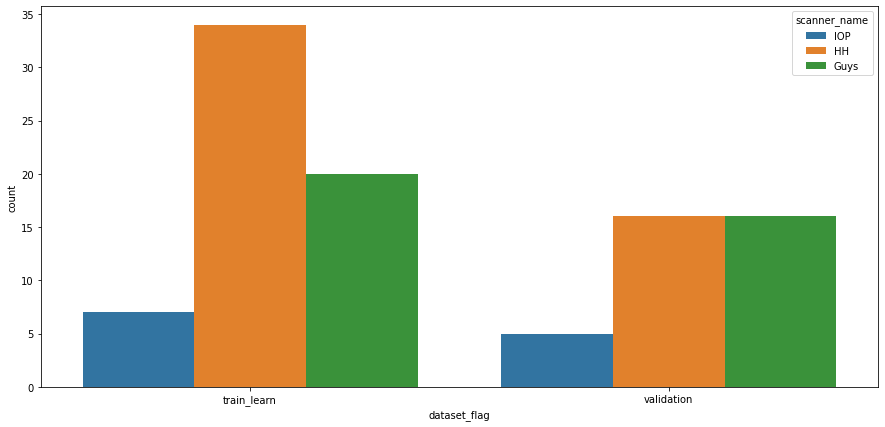

In [ ]:
plt.figure(figsize=(15, 7))
sns.countplot(x="dataset_flag", data=filtered_df, hue="scanner_name")

In [ ]:
train_learn_df = filtered_df[filtered_df["dataset_flag"] == "train_learn"]
train_learn_df.reset_index(inplace=True)
train_unlearn_df = filtered_df[filtered_df["dataset_flag"] == "train_unlearn"]
validation_df = filtered_df[filtered_df["dataset_flag"] == "validation"]
validation_df.reset_index(inplace=True)

In [ ]:
train_learn_df.head(5)

,index,IXI_ID,SEX_ID,HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,our_ixi_id,scanner_name,contrast_type,file_path,age_disc,dataset_flag,scanner_flag,contrast_flag,sex_flag
0,0,430,2,166,70,1,4,5,5,1934-07-02,1,2006-07-04,72.005476,430,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,70-80,train_learn,2,0,1
1,1,430,2,166,70,1,4,5,5,1934-07-02,1,2006-07-04,72.005476,430,IOP,T2,/content/drive/My Drive/Image_Registration_Pro...,70-80,train_learn,2,1,1
2,4,439,2,158,67,1,2,1,2,1962-06-03,1,2006-05-04,43.917864,439,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,40-50,train_learn,0,0,1
3,6,441,2,159,69,1,1,1,5,1958-04-18,1,2006-05-25,48.101300,441,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,40-50,train_learn,0,0,1
4,8,451,2,160,60,1,1,1,5,1965-06-09,1,2006-07-27,41.130732,451,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,40-50,train_learn,0,0,1


In [ ]:
z_64_slices = []
for i in range(0, 128, 2):
  z_64_slices.append(i)

In [ ]:
z_32_slices = []
for i in range(0, 128, 4):
  z_32_slices.append(i)

In [ ]:
fp2 = train_learn_df["file_path"].iloc[195]
fp2

In [ ]:
len(train_learn_df.index.tolist())

131

In [ ]:
def load_4D(name):
        model_np = np.zeros(shape=(128, 128, 128))
        resamplng_shape = (128, 128, 128)
        X_nb = nb.load(name)
        #print(X_nb)
        X_np = X_nb.dataobj
        #print(X_np)
        x_dim, y_dim, z_dim = X_np.shape
        #print(x_dim, y_dim, z_dim)
        x_ltail = (resamplng_shape[0] - x_dim)//2 
        y_ltail = (resamplng_shape[1] - y_dim)//2
        z_ltail = (resamplng_shape[2] - z_dim)//2
        #print(x_ltail,y_ltail,z_ltail)

        x_rtail = resamplng_shape[0] - x_ltail - 1
        y_rtail = resamplng_shape[1] - y_ltail - 1
        z_rtail = resamplng_shape[2] - z_ltail - 1
        #print(x_rtail,y_rtail,z_rtail)
        model_np[x_ltail:x_rtail, y_ltail:y_rtail, z_ltail:z_rtail] = X_np[:, :, :]
        #z_32_slices = [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127]
        model_np = model_np[:, :, 64]
        model_np = np.expand_dims(model_np, axis=0)
        #print(model_np.shape)
        #print(model_np)
        return model_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2

def Norm_Zscore(img):
    img= (img-np.mean(img))/np.std(img) 
    return img

def save_img(I_img,savename):
    I2 = sitk.GetImageFromArray(I_img,isVector=False)
    sitk.WriteImage(I2,savename)

In [ ]:
class Dataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, df = filtered_df, iterations =1, norm=True):
        self.df = df
        self.norm = norm
        self.iterations = iterations
        self.s0 = self.df[self.df["scanner_flag"] == 0].index.tolist()
        self.s1 = self.df[self.df["scanner_flag"] == 1].index.tolist()
        self.s2 = self.df[self.df["scanner_flag"] == 2].index.tolist()
        
  def __len__(self):
        'Denotes the total number of samples'
        # return self.df.shape[0] * self.iterations
        return 50

  def __getitem__(self, step):
        'Generates one sample of data'
        # index_pair = np.random.permutation(len(self.names)) [0:4]
        """
        fp = filtered_df["file_path"].iloc[step]
        sn = filtered_df["scanner_name"].iloc[step]
        dafl = filtered_df["dataset_flag"].iloc[step]
        agdi = filtered_df["age_disc"].iloc[step]
        """

        img1_contrast_flag = np.random.randint(3, size=1).item()
        img2_contrast_flag = (img1_contrast_flag+1)%3

        if (img1_contrast_flag == 0):
          i1_idx = np.random.choice(self.s0, 1).item()
          i2_idx = np.random.choice(self.s1, 1).item()
        elif (img1_contrast_flag == 1):
          i1_idx = np.random.choice(self.s1, 1).item()
          i2_idx = np.random.choice(self.s2, 1).item()
        else:
          i1_idx = np.random.choice(self.s2, 1).item()
          i2_idx = np.random.choice(self.s0, 1).item()

        # print(img1_contrast_flag, i1_idx, img2_contrast_flag, i2_idx)
        fp1 = self.df["file_path"].iloc[i1_idx]
        fp2 = self.df["file_path"].iloc[i2_idx]

        img1 = imgnorm(load_4D(fp1))  
        img2 = imgnorm(load_4D(fp2))   
        
        return img1, img2

In [ ]:
class IntermodalDataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1,norm=True):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.norm = norm
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        'Generates one sample of data'
        A_idx = randint(0, len(self.t1_filenames)-1)
        B_idx = A_idx
        # B_idx = randint(0, len(self.t2_filenames)-1)
        # if (A_idx == B_idx):
        #   B_idx = (B_idx + 1) % (len(self.t1_filenames)-1)

        #img_A = load_4D(self.t1_filenames[idx])
        #img_B = load_4D(self.t1_filenames[(idx + 4) % len(self.t1_filenames)])

        img_A = load_4D(self.t1_filenames[A_idx])
        img_B = load_4D(self.t2_filenames[B_idx])

        #print(A_idx, B_idx)
                       
        if self.norm:
            #return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
            full_img_A = imgnorm(img_A) 
            full_img_B = imgnorm(img_B)
            return  full_img_A , full_img_B
        else:
            return img_A, img_B

In [ ]:
#training_generator = Data.DataLoader(Dataset(train_learn_df, 1, True), batch_size=7,shuffle=True)

training_generator = Data.DataLoader(IntermodalDataset(file_names_t1, file_names_t2, 1, True), batch_size=7,shuffle=True)

In [ ]:
for  X, Y in training_generator:
  print(torch.max(X))
  print(X.shape)
  del X, Y
  break

tensor(1.)
torch.Size([7, 1, 128, 128])


In [ ]:
np.random.randint(3, size=1).item()

2

In [ ]:
np.random.permutation(2)[0:4]

array([0, 1])

# Model Creation

In [ ]:
class UnetEncoder(nn.Module):
  def __init__(self,in_channel, start_channel):
        self.in_channel = in_channel
        self.start_channel = start_channel
        super(UnetEncoder, self).__init__()
        self.en0_b0 = self.encoder(self.in_channel, self.start_channel * 1, bias=True)
        self.en1_b0 = self.encoder(self.start_channel * 1, self.start_channel * 1, bias=True)
        self.en2_b0 = self.encoder(self.start_channel * 1, self.start_channel * 2, stride=2, padding=61, bias=True, )

        self.en0_b1 = self.encoder(self.start_channel * 2, self.start_channel * 2, bias=True)
        self.en1_b1 = self.encoder(self.start_channel * 2, self.start_channel * 2, bias=True)
        self.en2_b1 = self.encoder(self.start_channel * 2, self.start_channel * 4, stride=2, padding=63, bias=True)

        self.en0_b2 = self.encoder(self.start_channel * 4, self.start_channel * 4, bias=True)
        self.en1_b2 = self.encoder(self.start_channel * 4, self.start_channel * 4, bias=True)
        self.en2_b2 = self.encoder(self.start_channel * 4, self.start_channel * 8, stride=2, padding=63, bias=True)

  def encoder(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
    layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias ),
                nn.BatchNorm2d(out_channels),
                nn.ReLU())
    return layer

  def forward(self, x):  
        enc_op_b0 = self.en0_b0(x)
        enc_op_b0 = self.en1_b0(enc_op_b0)
        enc_op_b0 = self.en2_b0(enc_op_b0)

        enc_op_b1 = self.en0_b1(enc_op_b0)
        enc_op_b1 = self.en1_b1(enc_op_b1)
        enc_op_b1 = self.en2_b1(enc_op_b1)

        enc_op_b2 = self.en0_b2(enc_op_b1)
        enc_op_b2 = self.en1_b2(enc_op_b2)
        enc_op_b2 = self.en2_b2(enc_op_b2)

        return enc_op_b0, enc_op_b1, enc_op_b2

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
class BetaHead(nn.Module):
  def __init__(self,in_channel, Cb=5, Ct=2):
        self.in_channel = in_channel
        self.Cb = Cb
        self.Ct = Ct

        super(BetaHead, self).__init__()
        self.probmaps = self.probability_map(self.in_channel, self.Cb * 1)

  def probability_map(self, in_channel, Cb, ks=3, st=1, pd=1, bi=True):
    layer = nn.Sequential(
                nn.Conv2d(in_channels=in_channel, out_channels = Cb, kernel_size=ks, stride=st, padding=pd, bias=bi),                
                nn.Sigmoid())
    return layer
  
  def onehotencode(self):
    layer = nn.Sequential(nn.functional.gumbel_softmax(tau=1, hard=False, dim=1),)
    return layer

  def forward(self, x):  
        pmap = self.probmaps(x)
        ohe = nn.functional.gumbel_softmax(pmap, tau=1, hard=False, dim=1)
        return pmap, ohe

In [ ]:
class ThetaHead(nn.Module):
  def __init__(self,in_channel, Ct=2):
        self.in_channel = in_channel
        self.Ct = Ct

        super(ThetaHead, self).__init__()
        self.td = self.theta_head(self.in_channel)

  def theta_head(self, in_channel):
    layer = nn.Sequential(
                nn.Conv2d(in_channels=in_channel, out_channels = 1, kernel_size=32, stride=2, padding=1, bias=True),
                nn.Flatten(),
                nn.Linear(2500, self.Ct))
    return layer

  def forward(self, x):  
        theta_op = self.td(x)
        return theta_op

In [ ]:
class ReconstructionHead(nn.Module):
  def __init__(self,in_channel, Cb=5, Ct=2):
        self.in_channel = in_channel
        self.Cb = Cb
        self.Ct = Ct
        super(ReconstructionHead, self).__init__()
        self.reconstruction_head = self.reconstruct()

  def reconstruct(self):
    layer = nn.Sequential(nn.Conv2d(in_channels=self.Cb+self.Ct,out_channels=1, stride=1, padding=1, kernel_size=3, bias=True ), )
    return layer

  def forward(self, input_recon): 
      batch_size = input_recon.shape[0] 
      #theta_reconstructed = theta.repeat(1, 128, 128).reshape(batch_size, self.Ct, 128, 128)
      #x_in = torch.cat((beta, theta_reconstructed), 1)
      rh = self.reconstruction_head(input_recon)
      return rh

In [ ]:
class RandomizationHead(nn.Module):
  def __init__(self, Cb=5, Ct=1):
        self.Cb = Cb
        self.Ct = Ct
        super(RandomizationHead, self).__init__()
        self.feature_map_selection_lst_recon1 = self.randomize_betas()
        self.feature_map_selection_lst_recon2 = self.randomize_betas()
        self.feature_map_selection_lst_recon3 = self.randomize_betas()
        self.feature_map_selection_lst_recon4 = self.randomize_betas()
        print("beta_selection1: {}".format(self.feature_map_selection_lst_recon1 ))
        print("beta_selection2: {}".format(self.feature_map_selection_lst_recon2 ))
        print("beta_selection3: {}".format(self.feature_map_selection_lst_recon3 ))
        print("beta_selection4: {}".format(self.feature_map_selection_lst_recon4 ))

  def randomize_betas(self):
        rnd_lst = np.random.choice(2, self.Cb, p=[0.5, 0.5]).tolist()

        for i in range(len(rnd_lst)):
          ln = len(rnd_lst) - 1
          if (rnd_lst[i] == 0):
            rnd_lst[i] = rnd_lst[i] + i
          else:
            rnd_lst[i] = rnd_lst[i] + ln + i  
          
        return rnd_lst

  def forward(self, beta1, beta2, theta1, theta2): 

      self.feature_map_selection_lst_recon1 = self.randomize_betas()
      self.feature_map_selection_lst_recon2 = self.randomize_betas()
      self.feature_map_selection_lst_recon3 = self.randomize_betas()
      self.feature_map_selection_lst_recon4 = self.randomize_betas()
      
      batch_size = beta1.shape[0] 
      theta1_reconstructed = theta1.repeat(1, 128, 128).reshape(batch_size, self.Ct, 128, 128)
      theta2_reconstructed = theta1.repeat(1, 128, 128).reshape(batch_size, self.Ct, 128, 128)

      beta = torch.cat((beta1, beta2), dim=1)

      beta_recon1 = beta[:,self.feature_map_selection_lst_recon1, :, : ]
      beta_recon2 = beta[:,self.feature_map_selection_lst_recon2, :, : ]
      beta_recon3 = beta[:,self.feature_map_selection_lst_recon3, :, : ]
      beta_recon4 = beta[:,self.feature_map_selection_lst_recon4, :, : ]

      input_recon1 = torch.cat((beta_recon1, theta1_reconstructed), 1)
      input_recon2 = torch.cat((beta_recon2, theta2_reconstructed), 1)
      input_recon3 = torch.cat((beta_recon3, theta1_reconstructed), 1)
      input_recon4 = torch.cat((beta_recon4, theta2_reconstructed), 1)

      return input_recon1, input_recon2, input_recon3, input_recon4

In [ ]:
input = torch.randn(size=(2, 1, 128, 128))
input1 = torch.randn(size=(2, 3, 128, 128))
input_t1 = torch.randn(size=(2, 1, 128, 128))
input_t2 = torch.randn(size=(2, 1, 128, 128))
encoder = UnetEncoder(1, 8)
beta = BetaHead(16)
theta = ThetaHead(16, 1)
unet_model = UNet(1, 16)
recon = ReconstructionHead(6, 5, 1)
rndh = RandomizationHead()

beta_selection1: [0, 6, 7, 3, 4]
beta_selection2: [5, 1, 7, 3, 4]
beta_selection3: [5, 1, 7, 8, 9]
beta_selection4: [0, 1, 7, 3, 4]


In [ ]:
u1 = unet_model(input_t1)
p1, o1 = beta(u1)
t1  = theta(u1)

#r1 = recon(o1, t1)

In [ ]:
u2 = unet_model(input_t2)
p2, o2 = beta(u2)
t2  = theta(u2)
#r2 = recon(o2, t2)

In [ ]:
input_recon1, input_recon2, input_recon3, input_recon4 = rndh(o1, o2, t1, t2)

In [ ]:
r1 = recon(input_recon1)
r2 = recon(input_recon2)
r3 = recon(input_recon3)
r4 = recon(input_recon4)

Model tested

In [ ]:
x = torch.randn(size=(7,2))
y = x.repeat(1, 128, 128).reshape(7, 2, 128, 128)

In [ ]:
rnd_lst = np.random.choice(2, 5, p=[0.5, 0.5]).tolist()
print(rnd_lst)
for i in range(len(rnd_lst)):
  ln = len(rnd_lst) - 1
  if (rnd_lst[i] == 0):
    rnd_lst[i] = rnd_lst[i] + i
  else:
    rnd_lst[i] = rnd_lst[i] + ln + i  
  
print(rnd_lst)

[0, 1, 1, 0, 0]
[0, 6, 7, 3, 4]


In [ ]:
x.unsqueeze(1)

tensor([[4],
        [1]])

In [ ]:
t

tensor([[0.0101],
        [0.2455]], grad_fn=<AddmmBackward>)

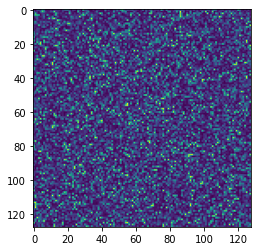

In [ ]:
plt.imshow(o[0, 0, :, :].detach().numpy())

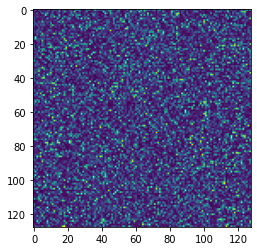

In [ ]:
plt.imshow(o[0, 1, :, :].detach().numpy())

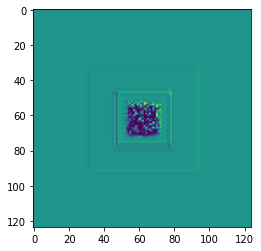

In [ ]:
plt.imshow(p[0, 4, :, :].detach().numpy())

In [ ]:
p[0, 1, :, :]

tensor([[0.4579, 0.4844, 0.4844,  ..., 0.4844, 0.4844, 0.4771],
        [0.4406, 0.4701, 0.4701,  ..., 0.4701, 0.4701, 0.4590],
        [0.4406, 0.4701, 0.4701,  ..., 0.4701, 0.4701, 0.4590],
        ...,
        [0.4406, 0.4701, 0.4701,  ..., 0.4701, 0.4701, 0.4590],
        [0.4406, 0.4701, 0.4701,  ..., 0.4701, 0.4701, 0.4590],
        [0.4458, 0.4731, 0.4731,  ..., 0.4731, 0.4731, 0.4567]],
       grad_fn=<SliceBackward>)

In [ ]:
o[0, 1, :, :]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], grad_fn=<SliceBackward>)

In [ ]:
print(x.shape)
print(y.shape)
print(z.shape)

torch.Size([2, 16, 124, 124])
torch.Size([2, 32, 124, 124])
torch.Size([2, 64, 124, 124])


In [ ]:
pretrained_unetmodel = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [ ]:
model_layers_lst = list(pretrained_unetmodel.children())

In [ ]:
model_layers_lst

In [ ]:
features = nn.ModuleList(pretrained_unetmodel.children())[:-1]
unetencoder = torch.nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1) , *(list(pretrained_unetmodel.children())[2:7]))
bb = nn.Sequential(nn.Conv2d(1, 3, 3, 1, 1), *(list(pretrained_unetmodel.children())[0:9]))
cc = nn.Sequential(*(list(pretrained_unetmodel.children())[9:-1]))
dd = nn.Sequential(*(list(pretrained_unetmodel.children())))

In [ ]:
print(bb)

In [ ]:
print(cc)

In [ ]:
op1 = bb(input)
print(op1.shape)
op2 = cc(op1)

In [ ]:
op3 = dd(input1)

RuntimeError: ignored

# Loss Functions and Miscellaneous

In [ ]:
def normalized_cross_correlation(x, y, return_map, reduction='mean', eps=1e-8):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        x (~torch.Tensor): Input tensor.
        y (~torch.Tensor): Input tensor.
        return_map (bool): If True, also return the correlation map.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'sum'``.
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
    Returns:
        ~torch.Tensor: Output scalar
        ~torch.Tensor: Output tensor
    """

    shape = x.shape
    b = shape[0]

    # reshape
    x = x.view(b, -1)
    y = y.view(b, -1)

    # mean
    x_mean = torch.mean(x, dim=1, keepdim=True)
    y_mean = torch.mean(y, dim=1, keepdim=True)

    # deviation
    x = x - x_mean
    y = y - y_mean

    dev_xy = torch.mul(x,y)
    dev_xx = torch.mul(x,x)
    dev_yy = torch.mul(y,y)

    dev_xx_sum = torch.sum(dev_xx, dim=1, keepdim=True)
    dev_yy_sum = torch.sum(dev_yy, dim=1, keepdim=True)

    ncc = torch.div(dev_xy + eps / dev_xy.shape[1],
                    torch.sqrt( torch.mul(dev_xx_sum, dev_yy_sum)) + eps)
    ncc_map = ncc.view(b, *shape[1:])

    # reduce
    if reduction == 'mean':
        ncc = torch.mean(torch.sum(ncc, dim=1))
    elif reduction == 'sum':
        ncc = torch.sum(ncc)
    else:
        raise KeyError('unsupported reduction type: %s' % reduction)

    if not return_map:
        return ncc
    
    if (torch.isclose(torch.tensor([-1.0]).to("cuda"), ncc).any()):
      ncc = ncc + torch.tensor([0.01]).to("cuda")

    elif (torch.isclose(torch.tensor([1.0]).to("cuda"), ncc).any()):
      ncc = ncc - torch.tensor([0.01]).to("cuda")

    return ncc, ncc_map


In [ ]:
class NormalizedCrossCorrelation(nn.Module):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
        return_map (bool, optional): If True, also return the correlation map. Defaults to False.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'mean'``.
    """
    def __init__(self,
                 eps=1e-8,
                 return_map=False,
                 reduction='mean'):

        super(NormalizedCrossCorrelation, self).__init__()

        self._eps = eps
        self._return_map = return_map
        self._reduction = reduction

    def forward(self, x, y):

        return normalized_cross_correlation(x, y,self._return_map, self._reduction, self._eps)

In [ ]:
cosine_similarity = torch.nn.CosineSimilarity(dim=2, eps=1e-08)
similarity_loss = cosine_similarity(o1.view(2,5,-1), o2.view(2,5,-1))
similarity_loss.mean(dim=1)

NameError: ignored

# Training

In [ ]:
del unet_model, betahead, thetahead, randomizehead, reconstructionhead
torch.cuda.empty_cache()

In [ ]:
unet_model = UNet(1, 16).to("cuda")

betahead = BetaHead(16).to("cuda")
thetahead = ThetaHead(16, 1).to("cuda")

randomizehead = RandomizationHead(5, 1).to("cuda")
reconstructionhead = ReconstructionHead(6, 5, 1).to("cuda")


beta_selection1: [5, 6, 2, 8, 9]
beta_selection2: [0, 1, 7, 8, 9]
beta_selection3: [5, 1, 7, 3, 4]
beta_selection4: [5, 1, 2, 8, 4]


In [ ]:
reconstruction_loss = NormalizedCrossCorrelation().to("cuda")
similarity_loss = torch.nn.CosineSimilarity(dim=2, eps=1e-08)
hyperparam1 = 1.0
hyperparam2 = -1.0
lmbda = 0.0005
lr=1e-3

In [ ]:
optimizer = torch.optim.Adam( list( unet_model.parameters()) + list( betahead.parameters() ) + 
                             list(thetahead.parameters()) + list(randomizehead.parameters()) + 
                             list( reconstructionhead.parameters()), lr=lr ) 
model_dir = '/content/drive/My Drive/Image_Registration_Project/disentangled_latent_space'

if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

In [ ]:
def fullmodel_one_epoch_run(epoch=1):
  example_number = 0
  reconstruction_loss_lst = []
  similarity_loss_lst = []
  total_loss_lst = []
  for X,Y in training_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()

    u_x = unet_model(X)
    p_x, o_x = betahead(u_x)
    t_x  = thetahead(u_x)

    u_y = unet_model(Y)
    p_y, o_y = betahead(u_y)
    t_y  = thetahead(u_y)

    input_recon1, input_recon2, input_recon3, input_recon4 = randomizehead(o_x, o_y, t_x, t_y)

    r1 = reconstructionhead(input_recon1)
    r2 = reconstructionhead(input_recon2)
    r3 = reconstructionhead(input_recon3)
    r4 = reconstructionhead(input_recon4)

    recon_loss_1 = reconstruction_loss(X, r1)
    recon_loss_2 = reconstruction_loss(Y, r2)
    recon_loss_3 = reconstruction_loss(X, r3)
    recon_loss_4 = reconstruction_loss(Y, r4)

    recon_loss = (recon_loss_1 + recon_loss_2 + recon_loss_3 + recon_loss_4)/4

    #print(recon_loss)

    sim_loss = similarity_loss(o_x.view(x_size[0], 5, -1), o_y.view(x_size[0], 5, -1))
    sim_loss = sim_loss.mean()

    #print(sim_loss)

    total_loss = hyperparam1 * recon_loss + hyperparam2 * lmbda * sim_loss

    #print(total_loss)

    optimizer.zero_grad()          
    total_loss.backward() 
    optimizer.step()

    reconstruction_loss_lst.append(recon_loss.detach().cpu().numpy().item())
    similarity_loss_lst.append(sim_loss.detach().cpu().numpy().item())
    total_loss_lst.append(total_loss.detach().cpu().numpy().item())
    #print("============= =============== ===========")

    del X, Y, u_x, p_x, t_x, u_y, p_y, t_y, input_recon1, input_recon2, input_recon3, input_recon4, r1, r2, r3, r4
    torch.cuda.empty_cache()    
    example_number = example_number + 1
    

  if (epoch%4 == 0):
    modelname = model_dir + '/' + "latent_space_harmonization_" + str(epoch+52) + '.pth'
    torch.save({"unet_model": unet_model.state_dict(), "beta": beta.state_dict(), "theta": theta.state_dict(),
                "randomizehead": randomizehead.state_dict(), "reconstructionhead": reconstructionhead.state_dict()}, modelname)
    print("epoch: {}".format(epoch+52))
    #print(similarity_loss_lst)
    print("Losses: {}, {} and {}".format(recon_loss*hyperparam1, sim_loss*hyperparam2*lmbda, total_loss))
    print("Average Losses: {}, {} {}".format(sum(reconstruction_loss_lst)/len(reconstruction_loss_lst), sum(abs(x) for x in similarity_loss_lst)/len(similarity_loss_lst) ,
                                            sum(abs(x) for x in total_loss_lst)/len(total_loss_lst) ) )
    print("Saving model checkpoints")
    print("======= =============== ===========")
    print()
  
  return reconstruction_loss_lst, similarity_loss_lst, total_loss_lst

In [ ]:
epochs = 101
a = []
b = []
c = []
for e in range(epochs):
  m,n,o = fullmodel_one_epoch_run(epoch=e)
  a.append(m)
  b.append(n)
  c.append(o)

epoch: 52
Losses: -0.6882099509239197, -0.00023792932915966958 and -0.688447892665863
Average Losses: -0.6869959916387286, 0.47750127741268705 0.687234742300851
Saving model checkpoints
======= =============== ===========

epoch: 56
Losses: -0.7125113606452942, -0.00023868028074502945 and -0.7127500176429749
Average Losses: -0.6981612358774457, 0.47735137598855154 0.6983999013900757
Saving model checkpoints
======= =============== ===========

epoch: 60
Losses: -0.6924126148223877, -0.00023911558673717082 and -0.6926517486572266
Average Losses: -0.6937205280576434, 0.47714334300586153 0.6939590999058315
Saving model checkpoints
======= =============== ===========

epoch: 64
Losses: -0.7109810709953308, -0.00023922898981254548 and -0.7112203240394592
Average Losses: -0.6870452676500592, 0.4775627723761967 0.6872840438570295
Saving model checkpoints
======= =============== ===========

epoch: 68
Losses: -0.6609257459640503, -0.00023911720199976116 and -0.6611648797988892
Average Losses: 

In [ ]:
similarity_loss_lst = [0.46767109632492065, 0.46727612614631653, 0.4673558473587036, 0.46867337822914124, 0.46916383504867554, 0.4692424237728119, 0.4691184461116791]
sum(abs(x) for x in similarity_loss_lst)/len(similarity_loss_lst) 

0.46835730757032124

# Validation and visualization